# Qubit Reuse Compilation

This notebook contains an overview of how to use the `pyqubit_reuse` package.

* [Simple Example](#simple-example)
* [Demonstrating compilation with qubit reuse for QAOA Circuits](#demonstrating-compilation-with-qubit-reuse-for-qaoa-circuits)
* [Additional Ordering Methods](#additional-ordering-methods)

## Simple Example <a class="anchor" id="simple-example"></a>

The Quantum hardware available today is typically considered to be error prone and to have a small number of qubits, popularised as Noisy Intermediate Scale Quantum, or NISQ, devices. In this setting, optimising compilers for quantum circuits can provide useful additional performance by finding and removing redundancies in quantum circuit programs written by quantum hardware users.

Most current techniques for circuit optimisation focus on reducing the number of gates in a circuit, often aiming to reduce the number of multi-qubit gates as they are known to be more error-prone. The prevailing logic is that a shorter circuit accumulates less noise and so provides better results.

The compilation technique available in this repository instead focuses on reducing the number of qubits, or width, of a circuit. This can help turn a circuit that at first seems infeasible on small near-term devices into one that we can run.

A full explanation of the techniques available in this repository can be read in the paper [Qubit-reuse compilation with mid-circuit measurement and reset](https://arxiv.org/abs/2210.08039) by Matthew DeCross, Eli Chertkov, Megan Kohagen and Michael Foss-Feig.

Let's first consider how such a technique is possible via a basic example. Consider the following 3-qubit circuit constructed using pytket:

In [1]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter

circuit = (
    Circuit(3, 3)
    .H(0)
    .CX(0, 1)
    .CX(1, 2)
    .Measure(0, 0)
    .Measure(1, 1)
    .Measure(2, 2)
)

render_circuit_jupyter(circuit)

We can run this through an H1 emulator to gather a set of shots as if running it on real hardware. Here we run without any TKET optimisations in stack applied.

In [3]:
from pytket.extensions.quantinuum import QuantinuumBackend

n_shots = 100

simulator_backend = QuantinuumBackend(device_name="H1-2E")
simulator_backend.login()

compiled_circuit = simulator_backend.get_compiled_circuit(circuit, optimisation_level=0)
handle = simulator_backend.process_circuit(compiled_circuit, n_shots, 
                                           options={'tket-opt-level': None})
result = simulator_backend.get_result(handle)

print(result.get_counts())

Enter your Quantinuum email: megan.l.kohagen@quantinuum.com
Enter your Quantinuum password: ········
Counter({(1, 1, 1): 55, (0, 0, 0): 43, (0, 1, 0): 2})


However, looking at the Circuit we can see that the `CX` gate targeting `q[2]` is executed after all the operations on `q[0]`. As an alternative Circuit, we could measure `q[0]`, reset it to the `0` state and then run the `CX` gate originally between `q[1]` and `q[2]` between `q[1]` and `q[0]`.

In [5]:
from pytket import OpType

circuit = (
    Circuit(2, 3)
    .H(0)
    .CX(0, 1)
    .Measure(0, 0)
    .add_gate(OpType.Reset, [0])
    .CX(1, 0)
    .Measure(1, 1)
    .Measure(0, 2)
)
render_circuit_jupyter(circuit)

In [6]:
compiled_circuit = simulator_backend.get_compiled_circuit(circuit, optimisation_level=0)
handle = simulator_backend.process_circuit(compiled_circuit, n_shots, 
                                           options={'tket-opt-level': None})
result = simulator_backend.get_result(handle)

print(result.get_counts())

Counter({(1, 1, 1): 55, (0, 0, 0): 45})


In this case, by reusing `q[0]` we've completed the same circuit using one fewer qubit.

This repository provides a `pytket` compiler pass for automatically applying qubit reuse schemes to `pytket` Circuit objects. If you are unfamiliar with compilation in `pytket` the [compilation example notebook](https://github.com/CQCL/pytket/blob/main/examples/compilation_example.ipynb) in the `pytket` repository covers the basics.

Lets construct a `QubitReuse` `CompilerPass` object and apply it to our original 3-qubit circuit.

One of the arguments for constructing the `CompilerPass` is a function for ordering. The reuse compilation works by finding causal cones of qubit outputs and merging qubits with disjoint causal cones. The order in which these causal cones are merged can effect the number of qubits in the output circuit, with an optimal ordering producing a circuit with a minimum number of qubits.

The `OrderingMethod` class provides four options for finding this ordering. For now we will look at the `BruteForceOrder` option.

In [7]:
from pyqubit_reuse import QubitReuse, OrderingMethod
from pytket.predicates import CompilationUnit

circuit = (
    Circuit(3, 3)
    .H(0).CX(0, 1)
    .CX(1, 2)
    .Measure(0, 0)
    .Measure(1, 1)
    .Measure(2, 2)
)

render_circuit_jupyter(circuit)

qubit_reuse_pass = QubitReuse(OrderingMethod.BruteForceOrder())
compilation_unit = CompilationUnit(circuit)
qubit_reuse_pass.apply(compilation_unit)
render_circuit_jupyter(compilation_unit.circuit)

As with the case we solved ourselves above, the `QubitReuse` pass is able to reduce the circuit from two to three qubits.

Not let's consider a real algorithm.

## Demonstrating compilation with qubit reuse for QAOA Circuits <a class="anchor" id="demonstrating-compilation-with-qubit-reuse-for-qaoa-circuits"></a>

Combinatorial optimization problems in quantum computing are defined by $n$ bits and $m$ clauses where each clause is a constraint on a subset of the bits which is either satisfied or unsatisfied for a given bitstring:

$C(x) = \sum\limits_{a=1}^{m}C_a(x)$

Alternatively, this can be considered as the problem of finding the maximum eigenvalue and its corresponding eigenstates for the following diagonal Hamiltonian:

$H = \sum\limits_{x\in\{0,1\}^{n}}C(x)|x\rangle\langle x|$ 

The paper [A Quantum Approximate Optimisation Algorithim](https://arxiv.org/abs/1411.4028) by Edward Farhi, Jeffrey Goldstone and Sam Gutmann details an algorithm for doing this.

A commonly tackled combinatorial optimization problem is the Max Cut problem: given some graph with $N$ nodes and $E$ edges, split the nodes into two subsets such that there is a maximum number of edges between both subsets. This is equivalent to finding the maximum eigenvalue and corresponding eigenstates for the following Hamiltonian: 

$H = \sum\limits_{(j,k)\in E} 0.5(1 - Z_jZ_k)$ 

Lets create a graph and consider an example problem using `networkx`.

**Note:** To run this example, run `pip install networkx` in your python environment.

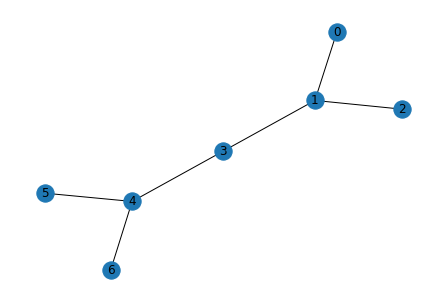

In [8]:
import networkx as nx

max_cut_graph_edges = [(0, 1), (1, 2), (1, 3), (3, 4), (4, 5), (4, 6)]
max_cut_graph = nx.Graph()
max_cut_graph.add_edges_from(max_cut_graph_edges)
nx.draw(max_cut_graph, labels={node: node for node in max_cut_graph.nodes()})

For this problem, having nodes `1` and `4` in the same subset (i.e. labelled differently to the remaining nodes) gives 6 edges between subsets, the maximum result.

[A Quantum Approximate Optimisation Algorithim](https://arxiv.org/abs/1411.4028) uses a variational algorithim with a paramterised circuit construction to find the maximum eigenvalue and corresponding eigenstates of the encoded Hamiltonian. From here on we will not look at how to solve the problem, but instead take the circuit construction proposed and show how qubit reuse can reduce the number of qubits in the circuit. 

To do so, we will define two functions, one to convert the edges of a graph to our cost Hamiltonian, represented by the `pytket` `QubitPauliOperator` object, the other to convert the edges of a graph to a `pytket` `Circuit`.

In [9]:
from typing import List, Tuple
from pytket.utils import QubitPauliOperator, gen_term_sequence_circuit
from pytket.pauli import QubitPauliString, Pauli
from pytket import Qubit
from pytket.passes import DecomposeBoxes


def qaoa_graph_to_cost_hamiltonian(edges: List[Tuple[int, int]], 
                                   cost_angle: float) -> QubitPauliOperator:
    """ Convert QAOA graph to cost Hamiltonian. """
    qpo_dict = {QubitPauliString(): len(edges) * 0.5 * cost_angle}
    for e in edges:
        term_string = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Z, Pauli.Z])
        qpo_dict[term_string] = -0.5 * cost_angle
    return QubitPauliOperator(qpo_dict)


def gen_qaoa_max_cut_circuit(edges: List[Tuple[int, int]],
                             n_nodes: int,
                             mixer_angles: List[float],
                             cost_angles: List[float],) -> Circuit:
    """ Generate QAOA MaxCut circuit. """
    assert len(mixer_angles) == len(cost_angles)

    # initial state
    qaoa_circuit = Circuit(n_nodes)
    for qubit in range(n_nodes):
        qaoa_circuit.H(qubit)

    # add cost and mixer terms to state
    for cost, mixer in zip(cost_angles, mixer_angles):
        cost_ham = qaoa_graph_to_cost_hamiltonian(edges, cost)
        mixer_ham = QubitPauliOperator(
            {QubitPauliString([Qubit(i)], [Pauli.X]): mixer for i in range(n_nodes)}
        )
        qaoa_circuit.append(gen_term_sequence_circuit(cost_ham, Circuit(n_nodes)))
        qaoa_circuit.append(gen_term_sequence_circuit(mixer_ham, Circuit(n_nodes)))

    DecomposeBoxes().apply(qaoa_circuit)
    qaoa_circuit.measure_all()
    return qaoa_circuit

The `mixer_angles` and `cost_angles` inputs are the parameterised values used to explore the solution space and find the maximum eigenvalue and corresponding eigenstates. For this example, which is only considering qubit reuse, we will set them arbitrarily to values that won't be optimised away.

In [10]:
qaoa_circuit = gen_qaoa_max_cut_circuit(max_cut_graph_edges, 7, [0.3], [0.3])
render_circuit_jupyter(qaoa_circuit)

We've constructed a 7-qubit circuit: an intuitive explanation of the circuit constructed may be that each edge in the graph corresponds to a ZZ term in the Hamiltonian, and each ZZ term in the Hamiltonian corresponds to a ZZ Pauli Gadget in the circuit.

Can qubit reuse reduce this? 

Here the `BruteForceOrder` `OrderingMethod` is used. This will take a long time to run since it will calculate and score every possible ordering for merging causal cones, with the number of orders scaling exponentially.

In [11]:
compilation_unit = CompilationUnit(qaoa_circuit)
qubit_reuse_pass.apply(compilation_unit)
render_circuit_jupyter(compilation_unit.circuit)

In [12]:
print("Reused Circuit has", compilation_unit.circuit.n_qubits, "qubits.")

Reused Circuit has 2 qubits.


By applying the qubit reuse pass we're able to reduce the number of qubits in the Circuit from 7 to 2. 

Lets consider a larger, random problem.

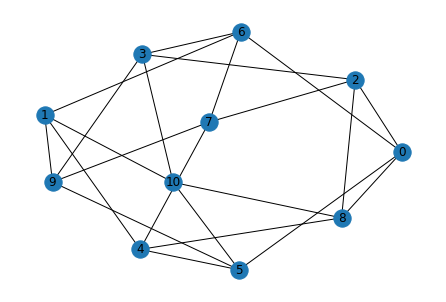

In [13]:
random_11_node_graph = nx.random_regular_graph(4, 11)
nx.draw(
    random_11_node_graph, labels={node: node for node in random_11_node_graph.nodes()}
)

In [14]:
random_11_node_graph_edges = list(random_11_node_graph.edges())
qaoa_circuit_11 = gen_qaoa_max_cut_circuit(random_11_node_graph_edges, 11, [0.3], [0.3])
render_circuit_jupyter(qaoa_circuit_11)

In [15]:
compilation_unit = CompilationUnit(qaoa_circuit_11)
qubit_reuse_pass.apply(compilation_unit)
render_circuit_jupyter(compilation_unit.circuit)

In [16]:
print("Reused Circuit has", compilation_unit.circuit.n_qubits, "qubits.")

Reused Circuit has 7 qubits.


Given this, the qubit reuse package comes with several other `OrderingMethod` functions for finding solutions for larger problems. Lets see how each of them perform for a much larger problem.

## Additional Ordering Methods <a class="anchor" id="additional-ordering-methods"></a>

Note that all the functions provided below correspond to the techniques outlined in [Qubit-reuse compilation with mid-circuit measurement and reset](https://arxiv.org/abs/2210.08039).

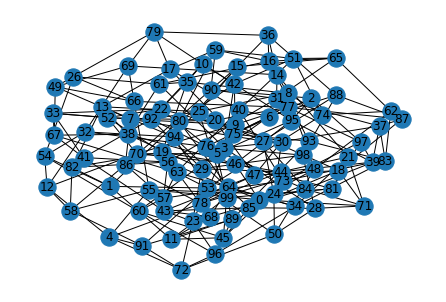

In [17]:
random_100_node_graph = nx.random_regular_graph(5, 100)
nx.draw(
    random_100_node_graph, labels={node: node for node in random_100_node_graph.nodes()}
)

In [18]:
random_100_node_graph_edges = list(random_100_node_graph.edges())
qaoa_circuit_100 = gen_qaoa_max_cut_circuit(
    random_100_node_graph_edges, 100, [0.3], [0.3]
)

Using `OrderingMethod.LocalGreedyOrder()`.

In [19]:
compilation_unit = CompilationUnit(qaoa_circuit_100)
qubit_reuse_pass_local_greedy = QubitReuse(OrderingMethod.LocalGreedyOrder())
qubit_reuse_pass_local_greedy.apply(compilation_unit)
print("Reused Circuit has", compilation_unit.circuit.n_qubits, "qubits.")

Reused Circuit has 50 qubits.


Using `OrderingMethod.LocalGreedyFirstNodeSearchOrder()`.

In [20]:
compilation_unit = CompilationUnit(qaoa_circuit_100)
qubit_reuse_pass_local_greedy_first_node_search_order = QubitReuse(
    OrderingMethod.LocalGreedyFirstNodeSearchOrder()
)
qubit_reuse_pass_local_greedy_first_node_search_order.apply(compilation_unit)
print("Reused Circuit has", compilation_unit.circuit.n_qubits, "qubits.")

Reused Circuit has 46 qubits.


For between 10 and 25 Qubits you may want to use `OrderingMethod.ConstrainedOptOrder()`. The `ConstrainedOptOrder` function corresponds to the Constraint Optimization method outlined in the paper, which finds the optimal reduced number of qubits. You may not want to use it beyond 25 qubits as it may take the Constraint Optimization solver a long time to find the optimal solution.

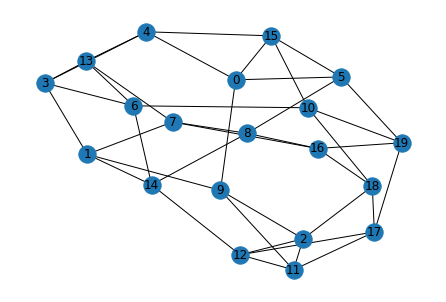

In [23]:
random_20_node_graph = nx.random_regular_graph(4, 20)
nx.draw(
    random_20_node_graph, labels={node: node for node in random_20_node_graph.nodes()}
)

In [24]:
random_20_node_graph_edges = list(random_20_node_graph.edges())
qaoa_circuit_20 = gen_qaoa_max_cut_circuit(random_20_node_graph_edges, 20, [0.3], [0.3])
render_circuit_jupyter(qaoa_circuit_20)

In [25]:
compilation_unit = CompilationUnit(qaoa_circuit_20)
qubit_reuse_pass_constrained_opt_order = QubitReuse(
    OrderingMethod.ConstrainedOptOrder()
)
qubit_reuse_pass_constrained_opt_order.apply(compilation_unit)
render_circuit_jupyter(compilation_unit.circuit)
print("Reused Circuit has", compilation_unit.circuit.n_qubits, "qubits.")

Reused Circuit has 10 qubits.


`OrderingMethod.DefaultOrder()` switches between the four ordering methods shown depending on the number of qubits.

In [26]:
compilation_unit = CompilationUnit(qaoa_circuit_20)
qubit_reuse_pass_default_order = QubitReuse(OrderingMethod.DefaultOrder())
qubit_reuse_pass_default_order.apply(compilation_unit)
render_circuit_jupyter(compilation_unit.circuit)
print("Reused Circuit has", compilation_unit.circuit.n_qubits, "qubits.")

Reused Circuit has 10 qubits.


Finally, there is `OrderingMethod.CustomOrder()` which uses an order specified at construction.

In [27]:
compilation_unit = CompilationUnit(qaoa_circuit_20)
qubit_reuse_pass_default_order = QubitReuse(OrderingMethod.CustomOrder(range(0, 20)))
qubit_reuse_pass_default_order.apply(compilation_unit)
render_circuit_jupyter(compilation_unit.circuit)
print("Reused Circuit has", compilation_unit.circuit.n_qubits, "qubits.")

Reused Circuit has 16 qubits.


The `QubitReuse` pass has two further parametrisations that can be used. 

The first is `DualStrat`. Given that some of the available reodering methods are heuristics, sometimes a better solution can be found by running the algorithim on a similar problem that can be easily mapped to a correct solution. In this case, we can run the qubit reuse scheme on the reverse circuit and then reverse it again to get a logically equivalent circuit. 

`DualStrat` has three options: `Single`, `Dual` and `Auto`. `Single` runs the qubit reuse algorithm on the given circuit only. `Dual` runs the qubit reuse algorithm on the reversed circuit and `Auto` runs on both the given and reversed circuit and returns the circuit with fewer qubits. If both circuits have the same number of qubits it returns the circuit with better depth, defaulting to the `None` strategy if both are deemed equivalent.  By default `Auto` is used.

We will look at how to run it using the previous QAOA examples.

In [28]:
from pyqubit_reuse import DualStrat

compilation_unit = CompilationUnit(qaoa_circuit_20)
qubit_reuse_pass_default_order = QubitReuse(
    OrderingMethod.DefaultOrder(), dual_strat=DualStrat.Dual
)
qubit_reuse_pass_default_order.apply(compilation_unit)
render_circuit_jupyter(compilation_unit.circuit)
print("Reused Circuit has", compilation_unit.circuit.n_qubits, "qubits.")

Reused Circuit has 10 qubits.


In [29]:
print("Reused Circuit has", compilation_unit.circuit.n_gates, "gates.")

Reused Circuit has 230 gates.


We can also set a minimum number of qubits as a target for the qubit reuse algorithm, which guarantees that the returned circuit has at least that many qubits.

We can take the QAOA problem we have just run and specify a minimum number of qubits larger than the 10 it returned.

In [30]:
compilation_unit = CompilationUnit(qaoa_circuit_20)
qubit_reuse_pass_default_order = QubitReuse(
    OrderingMethod.DefaultOrder(), dual_strat=DualStrat.Dual, min_qubits=11
)
qubit_reuse_pass_default_order.apply(compilation_unit)
render_circuit_jupyter(compilation_unit.circuit)
print("Reused Circuit has", compilation_unit.circuit.n_qubits, "qubits.")

Reused Circuit has 11 qubits.


In [31]:
print("Reused Circuit has", compilation_unit.circuit.n_gates, "gates.")

Reused Circuit has 229 gates.


We can see the by specifying a minimum of 11 qubits, the returned circuit is now larger. 

Finally, in some algorithmic scenarios we may be able to reason that the outcome results of certain qubits are not necessary to the full algorithm being run. For this scenario we provide a method in `pyqubit_reuse` called `correlation_subcircuit` which given a list of `Qubit` and `Bit` that are known to be required, returns a new `Circuit` only containing operations in the causal cones of the `Qubit` and `Bit` given. 

In [32]:
from pyqubit_reuse import correlation_subcircuit
from pytket import Bit

correlated_qaoa_20 = correlation_subcircuit(
    qaoa_circuit_20, [Bit(i) for i in range(0, 5)]
)

render_circuit_jupyter(correlated_qaoa_20)
print("Correlated subcircuit has", correlated_qaoa_20.n_qubits, "qubits.")

Correlated subcircuit has 19 qubits.


We can then apply a `QubitReuse` pass to this.

In [33]:
compilation_unit = CompilationUnit(correlated_qaoa_20)
qubit_reuse_pass_default_order = QubitReuse(OrderingMethod.DefaultOrder())
qubit_reuse_pass_default_order.apply(compilation_unit)
render_circuit_jupyter(compilation_unit.circuit)
print("Reused Circuit has", compilation_unit.circuit.n_qubits, "qubits.")

Reused Circuit has 7 qubits.


As described in [Qubit-reuse compilation with mid-circuit measurement and reset](https://arxiv.org/abs/2210.08039), compilation of tensor network circuits can be improved with qubit-reuse. For instance, for a quantum circuit implementation of the (depth-D, binary, open boundary conditions) Multiscale Entanglement Renormalization Ansatz (MERA) defined on $2^D$ qubits, the full output can be measured with only $2D - 1$ qubits.

In [34]:
def isometry(circ: Circuit, l_Q: List[int]) -> None:
    """ Adds isometry circuit by modifying circ. """
    for i in range(0, len(l_Q), 2): 
        circ.U3(1/2, 1/2, 1/2, l_Q[i])
        circ.U3(1/2, 1/2, 1/2, l_Q[i+1])
        circ.CX(l_Q[i+1], l_Q[i])
        circ.Rz(1/2, l_Q[i])
        circ.Ry(1/2, l_Q[i+1])
        circ.CX(l_Q[i], l_Q[i+1])
        circ.Ry(1/2, l_Q[i+1])
        circ.CX(l_Q[i+1], l_Q[i])
        circ.U3(1/2, 1/2, 1/2, l_Q[i])
        circ.U3(1/2, 1/2, 1/2, l_Q[i+1])
        

def entangler(circ: Circuit, l_Q: List[int]) -> None:
    """ Adds entangler circuit by modifying circ. """
    for i in range(0, len(l_Q)-2, 2): 
        circ.U3(1/2, 1/2, 1/2, l_Q[i+1])
        circ.U3(1/2, 1/2, 1/2, l_Q[i+2])
        circ.CX(l_Q[i+2], l_Q[i+1])
        circ.Rz(1/2, l_Q[i+1])
        circ.Ry(1/2, l_Q[i+2])
        circ.CX(l_Q[i+1], l_Q[i+2])
        circ.Ry(1/2, l_Q[i+2])
        circ.CX(l_Q[i+2], l_Q[i+1])
        circ.U3(1/2, 1/2, 1/2, l_Q[i+1])
        circ.U3(1/2, 1/2, 1/2, l_Q[i+2])

def qMERA_circuit(depth: int) -> Circuit:
    """ Given a depth, returns a Multiscale Entangelemnt Renormalization Ansatz circuit."""
    n_qubits = 2**depth
    circ = Circuit(n_qubits, n_qubits)
    for j in range(depth):
        list_qb: List[int] = [i_nq for i_nq in range(0, n_qubits, n_qubits//(2**(j+1)))]    
        isometry(circ, list_qb)
        entangler(circ, list_qb)
     
    circ.measure_all()
    return circ


In [35]:
compilation_unit = CompilationUnit(qMERA_circuit(7))
print("Original circuit has", compilation_unit.circuit.n_qubits, "qubits.")
QubitReuse(OrderingMethod.LocalGreedyFirstNodeSearchOrder()).apply(compilation_unit)
print("Reused Circuit has", compilation_unit.circuit.n_qubits, "qubits.")

Original circuit has 128 qubits.
Reused Circuit has 13 qubits.


In the above, we took a MERA circuit originally defined on $2^7 = 128$ qubits and compressed it down to only require $2*7 - 1 = 13$ qubits to measure the full output, which agrees with the analytic result for optimal compression. Notice that the compilation in the above cell was performed with the heuristic `OrderingMethod.LocalGreedyFirstNodeSearchOrder()` but still returned the optimal result, demonstrating that the heuristic is able to capture optimal results on problems too large for brute force solvers.

In many practical applications like MERA, one is only interested in measuring local correlation functions like $\langle X_0 X_{64}\rangle$, requiring measurements on only a subset of the output qubits. For instance, suppose one is only interested in measuring such a correlation function involving qubits 0 and 64 in the MERA defined above. In that case, we can first define the restricted `correlation_subcircuit` corresponding to those circuits, before applying the qubit reuse pass to the restricted subcircuit.

In [36]:
correlated_qMera = correlation_subcircuit(
    qMERA_circuit(7), [Bit(0), Bit(64)]
)
compilation_unit = CompilationUnit(correlated_qMera)
QubitReuse(OrderingMethod.LocalGreedyFirstNodeSearchOrder()).apply(compilation_unit)
print("Reused Circuit has", compilation_unit.circuit.n_qubits, "qubits.")

Reused Circuit has 4 qubits.


Measuring the output of this restricted subcircuit requires only 4 qubits on hardware, less than the optimal compression of 13 that the entire output would require.

<div align="center"> &copy; 2023 by Quantinuum. All Rights Reserved. </div>